In [3]:
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
# 1. Load the Covertype dataset
#    (will download ~60 MB on first run)
cov = fetch_covtype(download_if_missing=True)
X, y = cov.data, cov.target

In [5]:
X, y = fetch_covtype(return_X_y=True)
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df["target"] = y

# Sample 10% from each class
df_sub = (
    df
    .groupby("target", group_keys=False)
    .apply(lambda grp: grp.sample(frac=0.10, random_state=42))
    .reset_index(drop=True)
)

# Split back into X and y if needed
X_filt = df_sub.drop("target", axis=1).values
y_filt = df_sub["target"].values

print("After filtering:", np.bincount(y_filt).astype(int))

After filtering: [    0 21184 28330  3575   275   949  1737  2051]


/tmp/ipython-input-5-1749060449.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=0.10, random_state=42))


In [6]:
# 3. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.2,
    stratify=y_filt,
    random_state=42
)

In [7]:
# 3. Define hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]   # 1 = Manhattan distance, 2 = Euclidean
}

In [8]:
# 4. GridSearchCV to find best hyperparams (optimize macro-F1)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [9]:
# 5. Predict on the test set
y_pred = best_knn.predict(X_test)

In [17]:
# 6. Compute performance metrics (macro-averaged for multiclass)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1-score (weighted): {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8972
Precision (weighted): 0.8969
Recall (weighted): 0.8972
F1-score (weighted): 0.8430

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.90      0.90      4237
           2       0.91      0.92      0.91      5666
           3       0.86      0.87      0.87       715
           4       0.84      0.78      0.81        55
           5       0.76      0.72      0.74       190
           6       0.78      0.75      0.77       348
           7       0.92      0.89      0.91       410

    accuracy                           0.90     11621
   macro avg       0.85      0.83      0.84     11621
weighted avg       0.90      0.90      0.90     11621



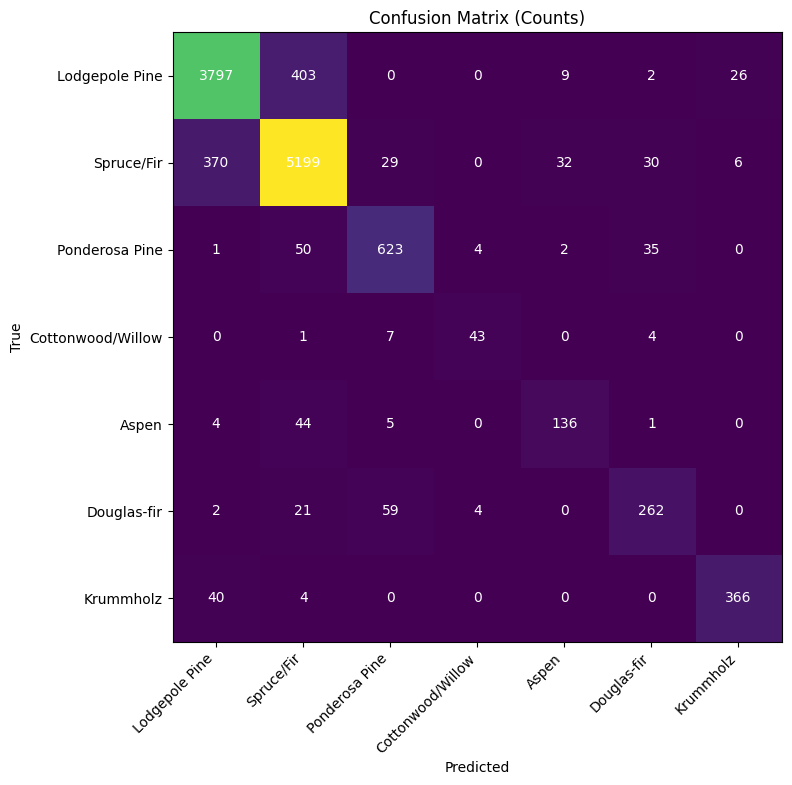

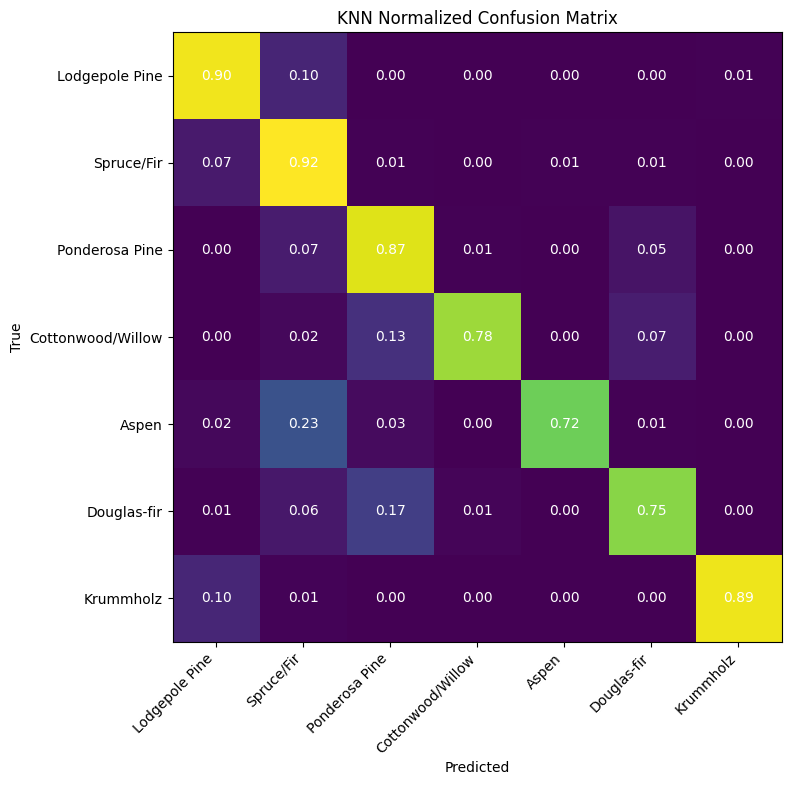

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Your fitted model and test set
# y_pred = best_knn.predict(X_test)

# 2. Mapping from label integers to names
class_names = {
    1: "Lodgepole Pine",
    2: "Spruce/Fir",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
}

# 3. Compute confusion matrices
labels = sorted(class_names.keys())  # [1,2,…,7]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# 4. Plot helper that uses class names
def plot_confusion(matrix, labels, names, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, [names[l] for l in labels], rotation=45, ha='right')
    plt.yticks(tick_marks, [names[l] for l in labels])
    fmt = '.2f' if matrix.dtype==float else 'd'
    thresh = matrix.max() / 2.
    for i, j in np.ndindex(matrix.shape):
        val = matrix[i, j]
        plt.text(j, i, format(val, fmt),
                 ha="center", va="center",
                 color="white")
    plt.tight_layout()

# 5. Plot raw counts
plot_confusion(cm, labels, class_names, title='Confusion Matrix (Counts)')

# 6. Plot normalized
plot_confusion(cm_norm, labels, class_names, title='KNN Normalized Confusion Matrix')

plt.show()


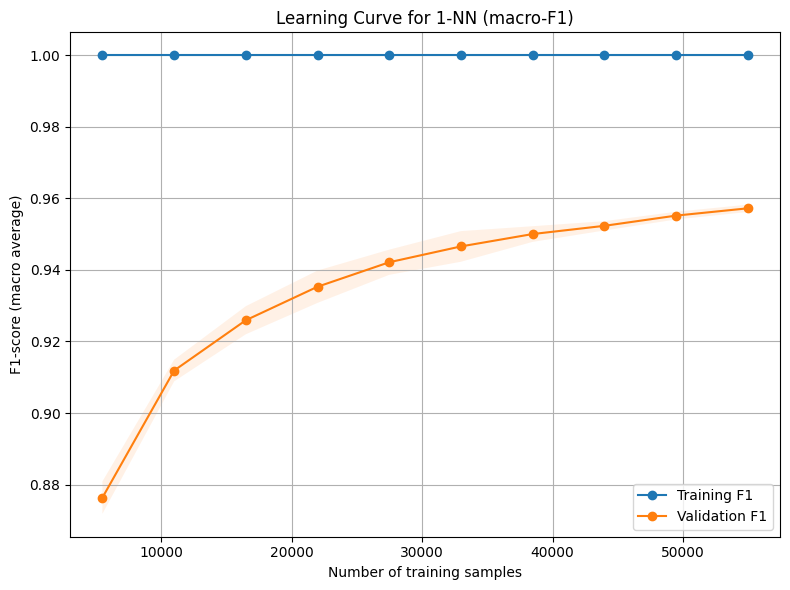

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --- assumes best_knn, X_train, y_train are already defined ---

# 1. Compute learning-curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_knn,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# 2. Compute mean & std dev across folds
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# 3. Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, marker='o', label='Validation F1')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.title('Learning Curve for 1-NN (macro-F1)')
plt.xlabel('Number of training samples')
plt.ylabel('F1-score (macro average)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()